# Consultas de la data analizada y mapa geografico de los datos


In [1]:
from tqdm import tqdm
# Spacy
import spacy
from spacy.matcher import Matcher
# Pandas
import pandas
from pandasql import sqldf
# Geopandas
import geopandas as gpd
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Transformers
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

/home/maquinitaz/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/maquinitaz/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
territory = gpd.read_file(r'./shape/comunas.shp', encoding='utf-8')
territory.columns.values


array(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry'], dtype=object)

In [3]:
territory=territory[territory["codregion"] == 10]

In [4]:
archivo = "./Dataset_Procesamiento_y_Analizado.csv"
dataset = pandas.read_csv(archivo)
dataset

,Unnamed: 0,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,...,Futaleufú,Hualaihué,Fresia,Quemchi,San_Juan_de_la_Costa,Curaco_de_Vélez,Queilén,Puqueldón,title_label,title_score
0,0,0,6,0.3955,"parte, millones, trabajo, proyecto, comuna, re...",Un total de 2.127 mesas receptoras de sufragio...,21887365.0,chile,radiosago,https://www.radiosago.cl/lenta-habilitacion-de...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEG,0.997895
1,1,1,5,0.6592,"investigación, víctima, fiscal, hechos, antece...",Detectives de la Brigada de Homicidios Puerto ...,21887883.0,chile,radiosago,https://www.radiosago.cl/pdi-detiene-a-sujeto-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.948319
2,2,2,0,0.5782,"años, personas, año, pandemia, días, horas, pa...",La Superintendencia de Salud hizo entrega de u...,21887884.0,chile,radiosago,https://www.radiosago.cl/superintendencia-de-s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.989732
3,3,3,0,0.4243,"años, personas, año, pandemia, días, horas, pa...",Debido al aumento de casos por COVID 19 y para...,21887888.0,chile,radiosago,https://www.radiosago.cl/aumentan-toma-de-pcr-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.997566
4,4,4,5,0.2773,"investigación, víctima, fiscal, hechos, antece...",A través de una carta dirigida al alcalde Gerv...,21887412.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-de...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEG,0.878784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4554,4554,4250,6,0.7030,"parte, millones, trabajo, proyecto, comuna, re...",Apuntando a entregar una mejorar calidad de ed...,47533616.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.768318
4555,4555,4251,0,0.3112,"años, personas, año, pandemia, días, horas, pa...","La elección de segunda vuelta presidencial, re...",47532745.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,POS,0.568555
4556,4556,4252,0,0.3575,"años, personas, año, pandemia, días, horas, pa...",Durante este tiempo de pandemia hemos visto qu...,47533619.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.985471
4557,4557,4253,6,0.5023,"parte, millones, trabajo, proyecto, comuna, re...","""Osorno, imágenes con Historia"" se llama el pr...",47532753.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.992794


- Visualizar los datos en un mapa

In [5]:
territory = territory[["Comuna", "geometry"]]
#Coordenadas de las comunas extraidas desde geometry
territory['coords'] = territory['geometry'].apply(lambda x: x.representative_point().coords[:]);
territory['coords'] = [coords[0] for coords in territory['coords']];

In [6]:
def save_map(df, territory, image_name: str = "Mapa_Calor"):
    
    #Junta las tablas df y Pais
    territory = territory.merge(df, on = "Comuna")
    
    #Inicializa matplotlib para la creacion del mapa
    
    territory.plot(column = 'Valor',edgecolor = "gray", cmap = 'OrRd', legend = True, figsize=(12, 15), linewidth=0.5).set_axis_off()

    for idx, row in territory.iterrows():
        plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center')

    plt.title("Menciones por comuna", fontsize=20)
    plt.text(0.5,0.1,"RegionLosLagos_2021-09-01_2021-12-31",fontsize=12, ha='center', transform=plt.gcf().transFigure)
    #Guardar imagen en nombre_imagen
    plt.savefig('.//{}.png'.format(image_name), bbox_inches = "tight",transparent = True)

In [7]:
def crear_mapa(dataset, territory, color):
    result = sqldf("SELECT sum(Ancud), sum(Calbuco), sum(Castro), sum(Chaitén), sum(Chonchi), sum(Cochamó), sum(Curaco_de_Vélez), sum(Dalcahue), sum(Fresia), sum(Frutillar), sum(Futaleufú), sum(Hualaihué), sum(Llanquihue), sum(Los_Muermos), sum(Maullín), sum(Osorno), sum(Palena), sum(Puerto_Montt), sum(Puerto_Octay), sum(Puerto_Varas), sum(Puqueldón), sum(Purranque), sum(Puyehue), sum(Queilén), sum(Quellón), sum(Quemchi), sum(Quinchao), sum(Río_Negro), sum(San_Juan_de_la_Costa), sum(San_Pablo) FROM dataset")
    Valores=result.values[0]
    ComunasArray=['Ancud','Calbuco','Castro','Chaitén','Chonchi','Cochamó','Curaco de Vélez','Dalcahue','Fresia','Frutillar','Futaleufú','Hualaihué','Llanquihue','Los Muermos','Maullín','Osorno','Palena','Puerto Montt','Puerto Octay','Puerto Varas','Puqueldón','Purranque','Puyehue','Queilén','Quellón','Quemchi','Quinchao','Río Negro','San Juan de la Costa','San Pablo']
    lista=[]
    i=0
    while i < len(ComunasArray):
        lista.append({"Comuna": ComunasArray[i], "Valor": Valores[i]})
        i=i+1
    df = pandas.DataFrame(lista)
    save_map(df, territory, "Mapa")

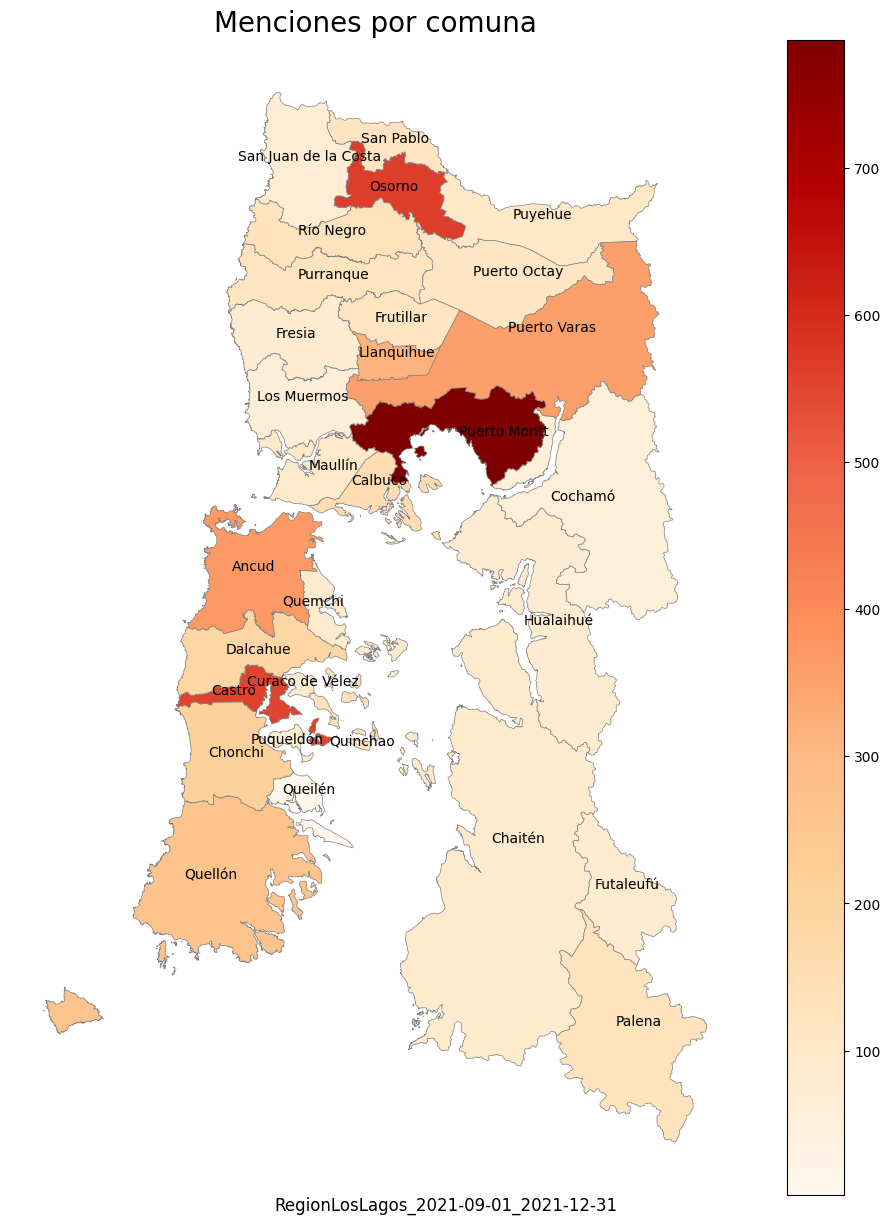

In [8]:
crear_mapa(dataset,territory,"rojo")